In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import h5py as h5

import re
import astropy.units as u
from scipy.spatial import cKDTree
from numba import njit, prange
from scipy.interpolate import interp1d
import matplotlib as mpl
from scipy.optimize import root_scalar
import glob

from rbf.interpolate import KNearestRBFInterpolant
from sklearn.cluster import KMeans
from joblib import Parallel, delayed

time_conv = 977.79222167

In [2]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5-RadFeed']
basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities', 'ParticleIDs'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f


In [3]:
basepath = '/n/home01/abeane/starbar/plots/bar_orbits/data/'
fin = h5.File(basepath + 'bar_orbit_Nbody-lvl4.hdf5', mode='r')

In [4]:
id_list = np.array(fin['id_list']).astype(np.int)

# np.array(fin['bar_metrics'][str(int(fin['id_list'][0]))])[:,1] < np.pi / 8.0

In [5]:
@njit
def process_id(ID, bar_metr, t, tlist, nsnap):
    in_bar = np.full(nsnap, 0, dtype=np.bool_)
    for j,idx in enumerate(range(nsnap)):
        Tanalyze = tlist[idx]
        key = np.argmin(np.abs(t - Tanalyze))
        
        metr = bar_metr[key]
        
        if metr[3] == 0.0:
            continue
        
        c0 = metr[1] < np.pi/8.0
        c1 = metr[2]/metr[3] < 0.22
        if c0 and c1:
            in_bar[j] = 1
    
    return in_bar


In [7]:
tlist = np.array(fin['tlist'])
nsnap = 1600

in_bar = np.full((nsnap, len(id_list)), 0, dtype=np.bool_)

for i,ID in enumerate(tqdm(id_list)):
    bar_metr = np.array(fin['bar_metrics'][str(ID)])
    t = tlist[bar_metr[:,0].astype(np.int)]
    in_bar[:,i] = process_id(ID, bar_metr, t, tlist, nsnap)
#     t = tlist[bar_metr[:,0].astype(np.int)]
#     for j,idx in enumerate(range(nsnap)):
#         Tanalyze = tlist[idx]
#         key = np.argmin(np.abs(t - Tanalyze))
    
#         metr = bar_metr[key]
#         c0 = metr[1] < np.pi/8.0
#         c1 = metr[2]/metr[3] < 0.22
#         if c0 and c1:
#             in_bar[i][j] = 1
        

    

A Jupyter Widget

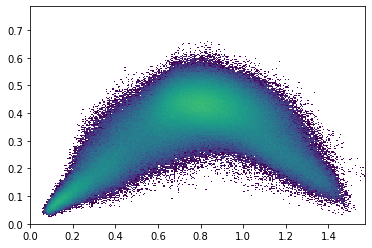

In [59]:
rng = [[0, np.pi/2.0], [0, np.pi/4.0]]
nres = 256

# heatmap, _, _ = np.histogram2d(metr_list[:,1], metr_list[:,2]/metr_list[:,3], range=rng, bins=(nres, nres))
heatmap, _, _ = np.histogram2d(metr_list[:,1], metr_list[:,4], range=rng, bins=(nres, nres))
extent = [rng[0][0], rng[0][1], rng[1][0], rng[1][1]]

fig, ax = plt.subplots(1, 1)
ax.imshow(heatmap.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('auto')
plt.show()

In [18]:
sn = read_snap(idx_analyze, 0, lvl='lvl4', parttype=[2])

In [56]:
pos_sorted = sn.part2.pos.value[np.argsort(sn.part2.id)]
vel_sorted = sn.part2.vel.value[np.argsort(sn.part2.id)]

In [71]:
c0 = metr_list[:,1] < np.pi/8.0
c1 = metr_list[:,2]/metr_list[:,3] < 0.22
# c2 = metr_list[:,4] < np.pi/8.0

key = np.logical_and(c0, c1)
print(len(np.where(key)[0]))

97851


/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [73]:
pos_bar = pos_sorted[key]
pos_notbar = pos_sorted[np.logical_not(key)]

vel_bar = vel_sorted[key]
vel_notbar = vel_sorted[np.logical_not(key)]

In [62]:
def make_plot(w, rng=[[-15, 15], [-15, 15]], nres=256, vmin=1E0, vmax=10.**(2.5), ang=0.0):
    fig, ax = plt.subplots(2, 1)
    x = w[:,0]
    y = w[:,1]
    
    Rx = x * np.cos(-ang) - y * np.sin(-ang)
    Ry = x * np.sin(-ang) + y * np.cos(-ang)
    
    heatmap, _, _ = np.histogram2d(Rx, Ry, range=rng, bins=(nres, nres))
    
    extent = [rng[0][0], rng[0][1], rng[1][0], rng[1][1]]
    ax.imshow(heatmap.T, extent=extent, origin='lower', 
                   norm=mpl.colors.LogNorm(), vmin=vmin, vmax=vmax)
    
    
    return fig, ax

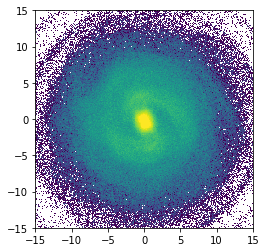

In [75]:
make_plot(pos_notbar)
plt.show()

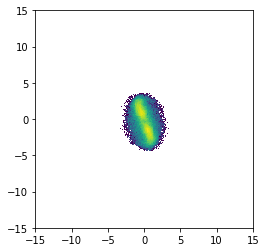

In [74]:
make_plot(pos_bar)
plt.show()

In [77]:
R_bar = np.linalg.norm(pos_bar[:,:2], axis=1)
R_notbar = np.linalg.norm(pos_notbar[:,:2], axis=1)

V_bar = (pos_bar[:,0] * vel_bar[:,1] - pos_bar[:,1] * vel_bar[:,0]) / R_bar
V_notbar = (pos_notbar[:,0] * vel_notbar[:,1] - pos_notbar[:,1] * vel_notbar[:,0]) / R_notbar

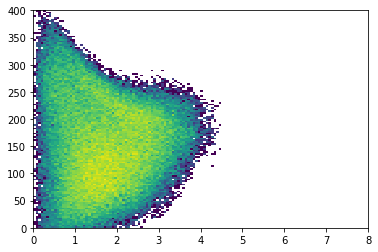

In [81]:
rng = [[0, 8.0], [0, 400]]
nres = 128

# heatmap, _, _ = np.histogram2d(metr_list[:,1], metr_list[:,2]/metr_list[:,3], range=rng, bins=(nres, nres))
heatmap, _, _ = np.histogram2d(R_bar, V_bar, range=rng, bins=(nres, nres))
extent = [rng[0][0], rng[0][1], rng[1][0], rng[1][1]]

fig, ax = plt.subplots(1, 1)
ax.imshow(heatmap.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('auto')
plt.show()

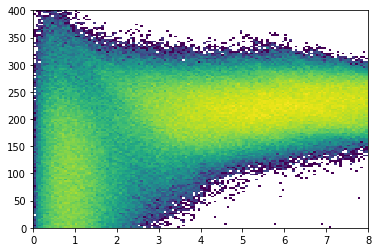

In [82]:
rng = [[0, 8.0], [0, 400]]
nres = 128

# heatmap, _, _ = np.histogram2d(metr_list[:,1], metr_list[:,2]/metr_list[:,3], range=rng, bins=(nres, nres))
heatmap, _, _ = np.histogram2d(R_notbar, V_notbar, range=rng, bins=(nres, nres))
extent = [rng[0][0], rng[0][1], rng[1][0], rng[1][1]]

fig, ax = plt.subplots(1, 1)
ax.imshow(heatmap.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('auto')
plt.show()

In [105]:
ftrapped_list = []
for i in range(np.shape(in_bar)[0]):
    in_bar_snap = in_bar[i]
    frac_trapped = len(np.where(in_bar_snap)[0]) / len(in_bar_snap)
    ftrapped_list.append(frac_trapped)



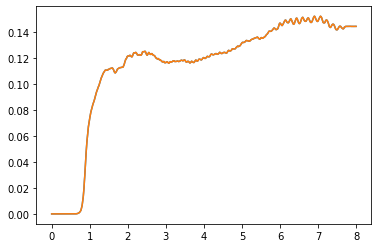

In [108]:
plt.plot(tlist[:1600], ftrapped_list)
plt.show()

In [8]:
idx_list = np.arange(0, 1600, 50)
bar_prop_list = []
for idx in tqdm(idx_list):
    frac_trapped = len(np.where(in_bar[idx])[0])/len(in_bar[idx])
    
    sn = read_snap(idx, 0, lvl='lvl4', parttype=[2])
    pos_sorted = sn.part2.pos.value[np.argsort(sn.part2.id)]
    vel_sorted = sn.part2.vel.value[np.argsort(sn.part2.id)]
    
    pos_inbar = pos_sorted[in_bar[idx]]
    vel_inbar = vel_sorted[in_bar[idx]]
    
    Mbar = sn.MassTable[2] * len(pos_inbar)
    Lzbar = sn.MassTable[2] * np.sum(np.cross(pos_inbar, vel_inbar)[:,2])
    
    
    R = np.linalg.norm(pos_inbar[:,:2], axis=1)
    Rbar = np.percentile(R, 99)
    
    bar_prop_list.append([sn.Time.value, frac_trapped, Rbar, Mbar, Lzbar])

bar_prop_list = np.array(bar_prop_list)
    

A Jupyter Widget

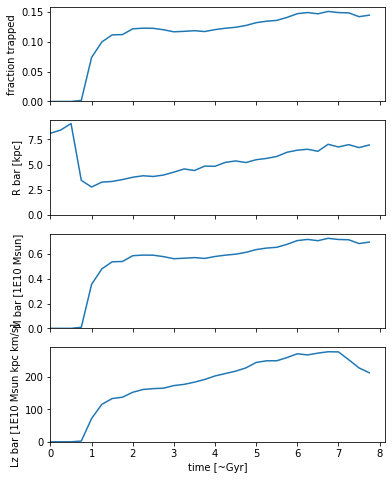

In [9]:
fig, ax = plt.subplots(4, 1, figsize=(6, 8), sharex=True)

ax[0].plot(bar_prop_list[:,0], bar_prop_list[:,1])
ax[1].plot(bar_prop_list[:,0], bar_prop_list[:,2])
ax[2].plot(bar_prop_list[:,0], bar_prop_list[:,3])
ax[3].plot(bar_prop_list[:,0], bar_prop_list[:,4])

ax[0].set(ylabel='fraction trapped', ylim=(0, None))
ax[3].set(xlabel='time [~Gyr]', ylabel='Lz bar [1E10 Msun kpc km/s]', ylim=(0, None))
ax[1].set(ylabel='R bar [kpc]', ylim=(0, None), xlim=(0, None))
ax[2].set(ylabel='M bar [1E10 Msun]', ylim=(0, None))

plt.show()

In [10]:
@njit
def compute_apoapses(orbit):

    # first find the apoapses
    N = len(orbit)
    rsq = np.zeros(N)
    for i in range(N):
        rsq[i] = orbit[i][0]**2 + orbit[i][1]**2 + orbit[i][2]**2

    is_apoapse = np.zeros(N)
    
    for i in range(1, N-1):
        if rsq[i] > rsq[i-1] and rsq[i] > rsq[i+1]:
            is_apoapse[i] = 1
    
    key_apo = np.where(is_apoapse==1)[0]
    apo = orbit[key_apo]
    
    return key_apo, apo

@njit
def loop_over_apoapses_compute_I(w, tlist, Trange):
    Tmin = Trange[0]
    Tmax = Trange[1]
    
    dat_out = np.zeros((w.shape[1], 4))
    
    for j in range(w.shape[1]):
        orbit = w[:,j]
        key_apo, _ = compute_apoapses(orbit[:,:3])
        t_apo = tlist[key_apo]
        
        # find the keys for the apoapses at edges of Trange
        for k in range(len(t_apo)):
            if t_apo[k] < Tmin and t_apo[k+1] > Tmin:
                Tmin_key0 = k
                Tmin_key1 = k + 1
            
            if t_apo[k] < Tmax and t_apo[k+1] > Tmax:
                Tmax_key0 = k
                Tmax_key1 = k + 1
                break
        
        Iz_Tmin = 0.0
        Iz_Tmax = 0.0
        Nmin = 0
        Nmax = 0
        
        for k in range(Tmin_key0, Tmin_key1):
            Iz_Tmin += (orbit[k][0]*orbit[k][4] - orbit[k][3]*orbit[k][1]) / np.sqrt(orbit[k][0]**2 + orbit[k][1]**2)
            Nmin += 1
        if Nmin > 0:
            Iz_Tmin /= float(Nmin)
        else:
            Iz_Tmin = np.nan
        
        for k in range(Tmax_key0, Tmax_key1):
            Iz_Tmax += (orbit[k][0]*orbit[k][4] - orbit[k][3]*orbit[k][1]) / np.sqrt(orbit[k][0]**2 + orbit[k][1]**2)
            Nmax += 1
        
        if Nmax > 0:
            Iz_Tmax /= float(Nmax)
        else:
            Iz_Tmax = np.nan
        
        k = Tmax_key0
        R_apo = np.sqrt(orbit[k][0]**2 + orbit[k][1]**2)
        V_apo = (orbit[k][0] * orbit[k][4] - orbit[k][3] * orbit[k][1]) / R_apo
        
        dat_out[j][0] = R_apo
        dat_out[j][1] = V_apo
        dat_out[j][2] = Iz_Tmin
        dat_out[j][3] = Iz_Tmax
        
    return dat_out
        


In [19]:
phase_space_path='/n/home01/abeane/starbar/plots/phase_space/data_tmp/'
name = 'Nbody-lvl4'

Trange = [2.5, 3.5]
center = np.array([0., 0., 0.])

nchunk = len(glob.glob(phase_space_path+name+'/phase_space_'+name+'.*.hdf5'))

dat_tot = np.array([]).reshape((0, 4))

for i in tqdm(range(nchunk)):
    fin = phase_space_path + name + '/phase_space_' + name + '.' + str(i) + '.hdf5'
    h5in = h5.File(fin, mode='r')
    
    tlist = np.array(h5in['Time'])
    pos = np.array(h5in['Coordinates']) - center
    vel = np.array(h5in['Velocities'])
        
    w = np.concatenate((pos, vel), axis=-1)
    w = np.swapaxes(w, 0, 1)
    
    dat = loop_over_apoapses_compute_I(w, tlist, Trange)
    dat_tot = np.concatenate((dat_tot, dat))
    

A Jupyter Widget

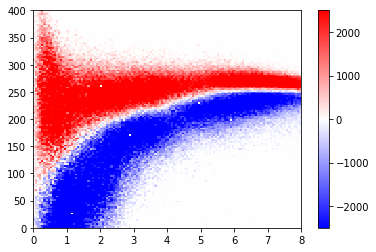

In [18]:
R_apo = dat_tot[:,0]
V_apo = dat_tot[:,1]
delta_Iz = dat_tot[:,3] - dat_tot[:,2]

# in_bar = 

rng = [[0, 8.0], [0, 400]]
nres = 128

# heatmap, _, _ = np.histogram2d(metr_list[:,1], metr_list[:,2]/metr_list[:,3], range=rng, bins=(nres, nres))
heatmap, _, _ = np.histogram2d(R_apo, V_apo, range=rng, bins=(nres, nres), weights=delta_Iz)
extent = [rng[0][0], rng[0][1], rng[1][0], rng[1][1]]

fig, ax = plt.subplots(1, 1)
im = ax.imshow(heatmap.T, extent=extent, origin='lower', vmin=-2500, vmax=2500, cmap='bwr')
fig.colorbar(im)
ax.set_aspect('auto')
plt.show()